# Study of the Supervised Descent Method in Face Alignement

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
import pickle

# Import modules
from src.get_data import get_data
from src.model import SDM
from sklearn.linear_model import LinearRegression,Ridge

## Dataset analysis

The first step in order to train the model is to create a training dataset, which will be constitued of picture of faces with a target landmark.


For this we use the `get_data` function, it returns train and test sets of instances of the Image class, each instance of image gets a true landmark that is used for learning or computing error.

For training landmarks are initiated at a mean face shape at the center of a box found by the haar cascade face finder model.

In [12]:
path_afw = r"data\ibug_300W_large_face_landmark_dataset\afw" 
path_lpfw=r"data\ibug_300W_large_face_landmark_dataset\lfpw\trainset"

DATA_PATH=path_lpfw

t0 = time.time()
train_data, test_data, mean_shape = get_data(DATA_PATH, train_split=0.8)
random.shuffle(train_data)
train_data=train_data[:2000]

print(f"Loaded data in {time.time()-t0:.2f} seconds.")
print(f"Number of train pictures : {len(train_data)}")
print(f"Number of test pictures : {len(test_data)}")

Data Cleaning: Kept 757 images. Rejected 54 bad detections.
Data loaded: 605 Train, 152 Test.
Generating augmented training data (10 per image)
Loaded data in 29.16 seconds.
Number of train pictures : 2000
Number of test pictures : 152


## SDM Model



### Training


In [13]:
# Parameters

n_step=5
model=Ridge(alpha=100) # LinearRegression()

In [14]:
# Fitting
use_saved=False
filename = "sdm_model.pkl"
if use_saved:
    with open(filename, "rb") as f:
        data_loaded = pickle.load(f)
    sdm=data_loaded["model"] 
    mean_shape=data_loaded["mean_shape"]
    sdm.extraction_function=cv2.SIFT_create()

else:
    t0 = time.time()
    sdm=SDM(n_step=n_step,model=model)
    sdm.fit(train_data)
    print(f"Finished training in {time.time()-t0:.2f} seconds.")

Training SDM on 2000 images for 5 steps.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.79094e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Step 1 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.55137e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Step 2 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.53471e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Step 3 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.68377e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Step 4 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.65345e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Step 5 done.
Finished training in 274.99 seconds.


In [15]:
# Save model

save=False
if save:
    sdm.extraction_function = None
    sauvegarde = {"model": sdm,"mean_shape": mean_shape}
    with open("sdm_model_5ksample_a100_adpataive_sift.pkl", "wb") as f:
        pickle.dump(sauvegarde, f)
    sdm.extraction_function=cv2.SIFT_create()

In [16]:
type(sdm)

src.model.SDM

### Visualization

Test in image 72


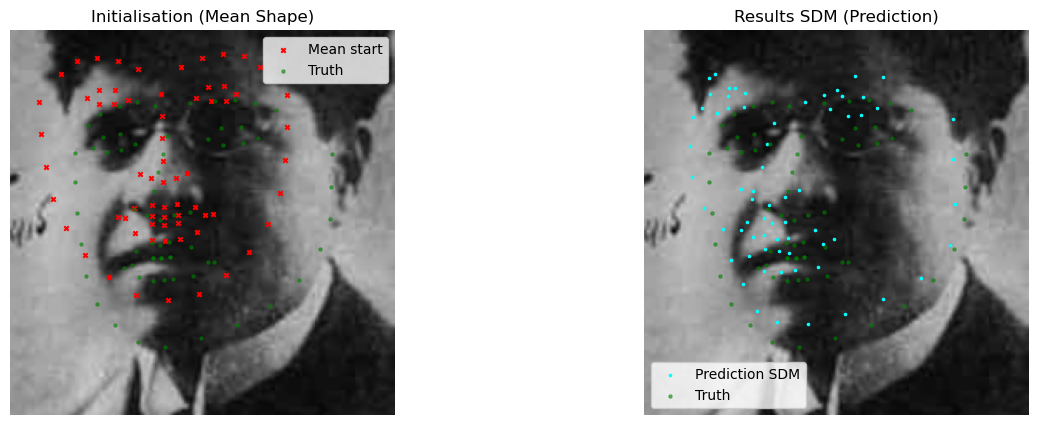

Test in image 144


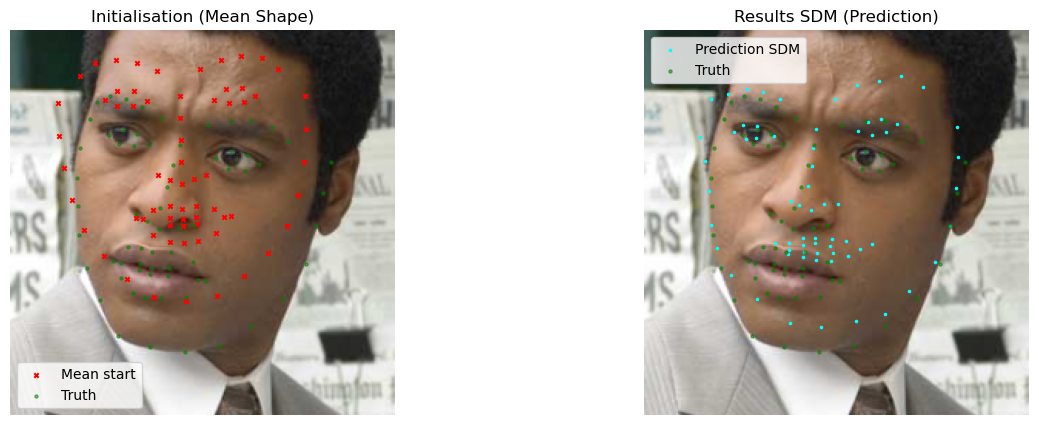

Test in image 37


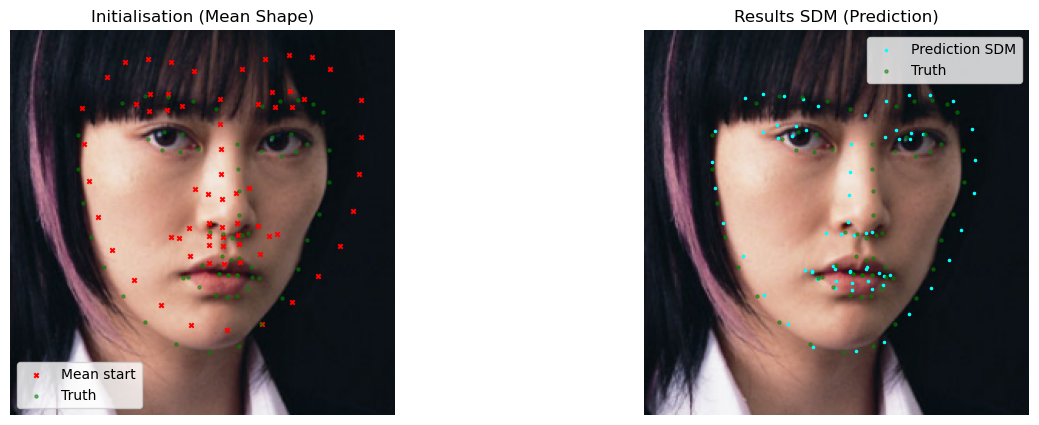

Test in image 109


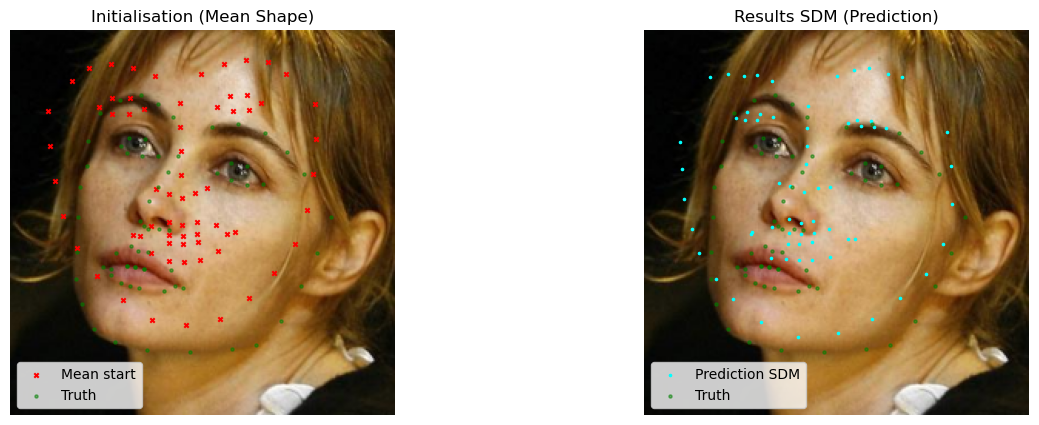

Test in image 51


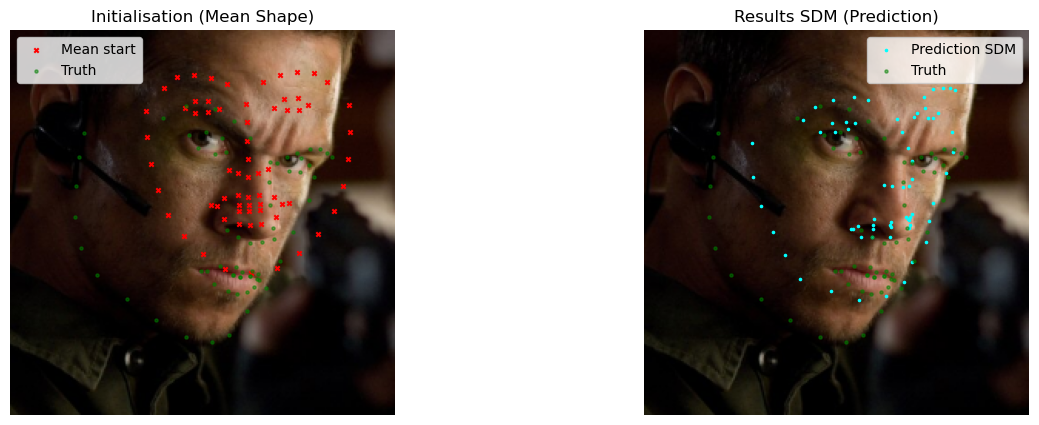

In [17]:
def visualize_result(sdm, image_obj):
    """
    Plot predictedd landmarks:
        Green is the true landmark (labels)
        Red is the mean face landmarks
        Blue is the predicted landmarks with SDM
    """
    # Predict new image
    predicted_image=sdm.predict(image_obj)
    predicted_landmark=predicted_image.current_landmark
    
    
    plt.figure(figsize=(15, 5))
    
    # Image before optimization
    plt.subplot(1, 2, 1)
    plt.title("Initialisation (Mean Shape)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
        
    plt.scatter(image_obj.current_landmark[:, 0], image_obj.current_landmark[:, 1], 
                c='red', s=10, marker='x', label='Mean start')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')

    # Image after optimization
    plt.subplot(1, 2, 2)
    plt.title("Results SDM (Prediction)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
    plt.scatter(predicted_landmark[:, 0], predicted_landmark[:, 1], 
                c='cyan', s=10, marker='.', label='Prediction SDM')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')
    
    plt.show()

for i in range(5):
    idx=random.randint(1,len(test_data))
    print(f"Test in image {idx}")
    visualize_result(sdm, test_data[idx])

### Test score

Global Score  : 19.6027


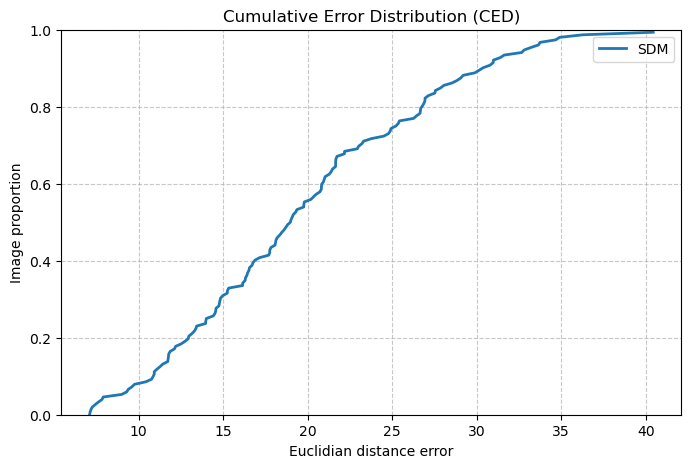

In [18]:
#Scores
mean_px, errors, worst_idx, max_error=sdm.evaluate_in_pixels(test_data)

print(f"Global Score  : {mean_px:.4f}")
sorted_errors = np.sort(errors)
proportions = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, proportions, label='SDM', linewidth=2)

plt.title("Cumulative Error Distribution (CED)")
plt.xlabel("Euclidian distance error")
plt.ylabel("Image proportion")
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.ylim(0, 1.0)
plt.legend()

plt.show()

### Error analysis

Get worst failures of the model, this is particularly useful to calibrate the model and fix issue.

Worst 3 failures
Image Index 119 - Erreur NME: 40.4411


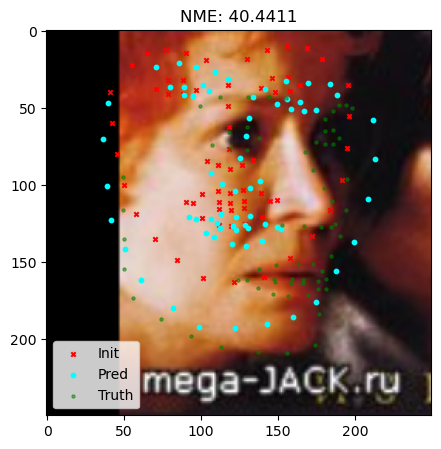

Image Index 18 - Erreur NME: 36.2885


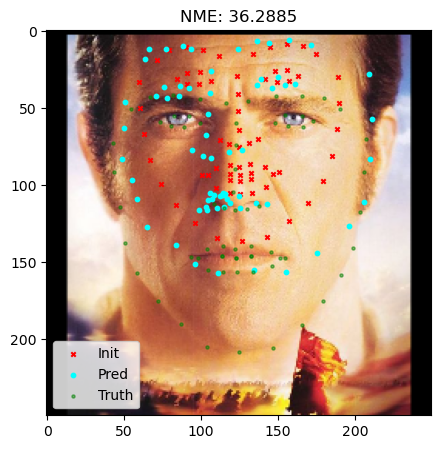

Image Index 50 - Erreur NME: 34.9125


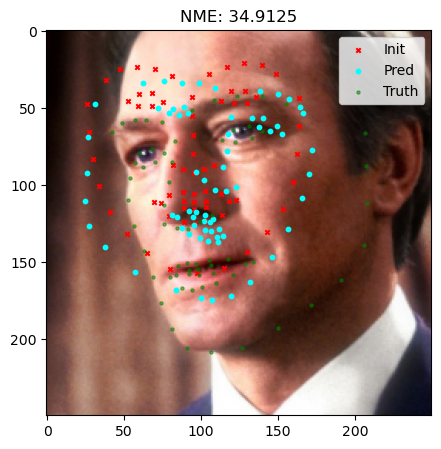

In [19]:
def show_worst_failures(model, test_data,all_errors, n=3):
    worst_indices = np.argsort(all_errors)[::-1][:n]
    print(f"Worst {n} failures")
    
    for idx in worst_indices:
        img_obj = test_data[idx]
        score = all_errors[idx]
        
        print(f"Image Index {idx} - Erreur NME: {score:.4f}")
        pred_img = model.predict(img_obj)
        
        plt.figure(figsize=(10, 5))
        if len(img_obj.image.shape) == 3:
            plt.imshow(cv2.cvtColor(img_obj.image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img_obj.image, cmap='gray')

        plt.scatter(img_obj.current_landmark[:, 0], img_obj.current_landmark[:, 1], 
                    c='red', s=10, marker='x', label='Init')
        plt.scatter(pred_img.current_landmark[:, 0], pred_img.current_landmark[:, 1], 
                    c='cyan', s=10, label='Pred')
        plt.scatter(img_obj.true_landmark[:, 0], img_obj.true_landmark[:, 1], 
                    c='green', s=5, alpha=0.5, label='Truth')
        
        plt.legend()
        plt.title(f"NME: {score:.4f}")
        plt.show()

show_worst_failures(sdm, test_data,errors)

In [20]:
print(f"\n--- Pixels results ---")
print(f"Mean Error: {mean_px:.2f} pixels")
print(f"Worst error in a single example : {max_error:.2f} pixels")
print(f"Index of worst image : {worst_idx}")


--- Pixels results ---
Mean Error: 19.60 pixels
Worst error in a single example : 40.44 pixels
Index of worst image : 119


Worst image sample :


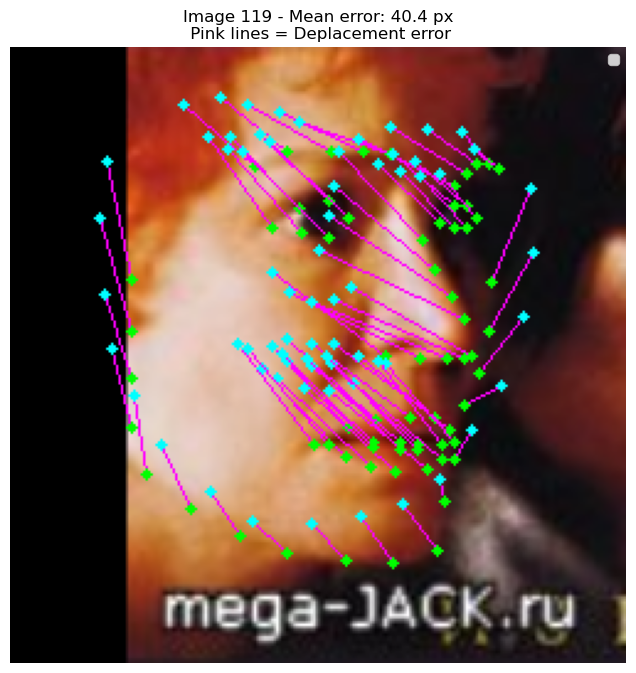

Random sample:


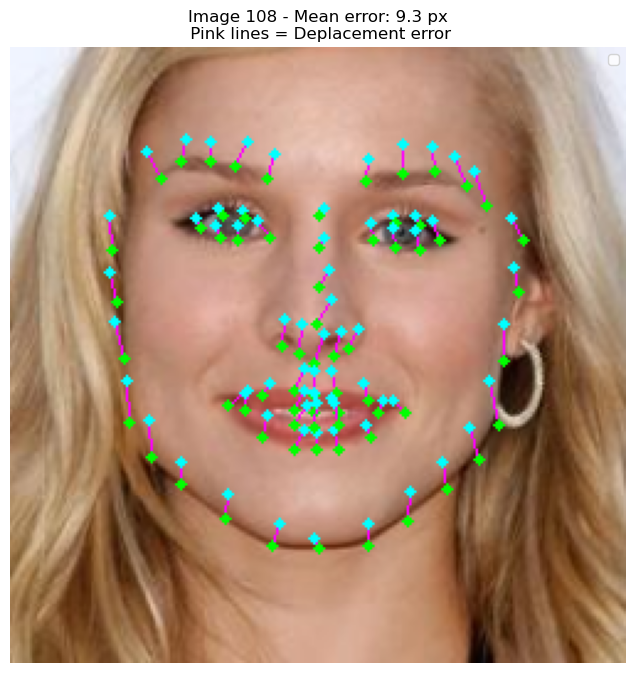

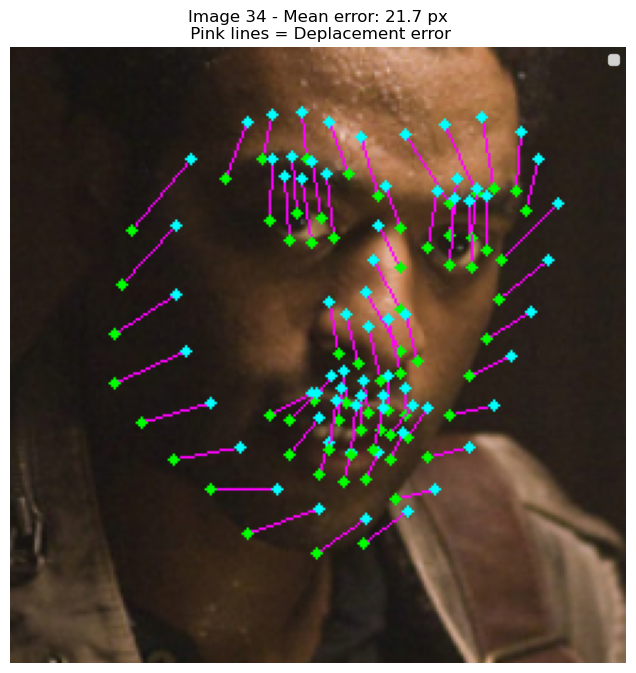

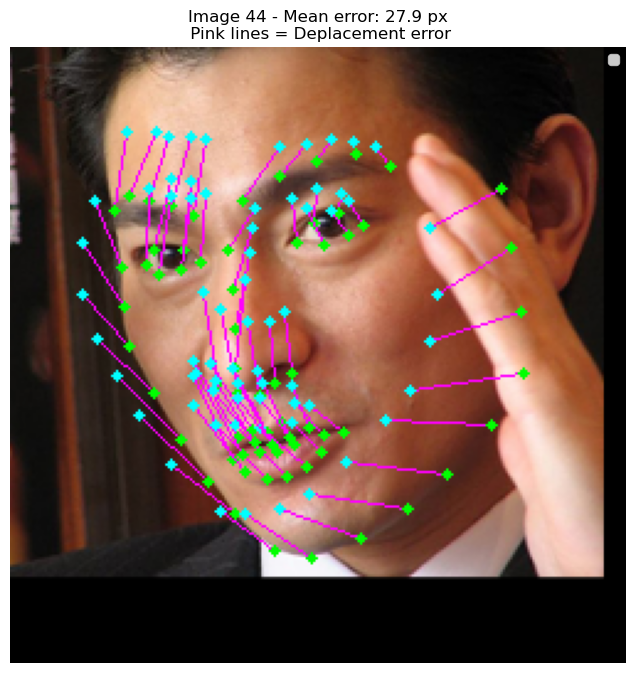

In [21]:
# See vector on worst sample
print("Worst image sample :")
sdm.visualize_error_vectors(test_data, image_indices=[worst_idx])

# vectors on random samples
print("Random sample:")
sdm.visualize_error_vectors( test_data)